In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist

In [16]:
file_path = "C:/Users/afili/Desktop/Uni/Mestrado/AASE/apartments_for_rent_100k_final.csv"
data_fixed = pd.read_csv(file_path, sep=';', on_bad_lines='skip', encoding='utf-8')

In [17]:
# 2. Definir as colunas que deseja verificar por outliers
numerical_features = ['price', 'square_feet', 'bathrooms', 'bedrooms']

# 3. Função para remover outliers usando IQR
def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Filtrar dados dentro dos limites
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

# 4. Aplicar a função para remover outliers
data_cleaned = remove_outliers(data_fixed, numerical_features)

# 5. Verificar o tamanho do dataset após remoção
print(f"Tamanho original do dataset: {data_fixed.shape}")
print(f"Tamanho após remoção de outliers: {data_cleaned.shape}")

Tamanho original do dataset: (99842, 53)
Tamanho após remoção de outliers: (92403, 53)


In [18]:
# Select relevant columns
features_valid = [
    'bathrooms', 'bedrooms', 'square_feet', 'AC', 'Alarm', 'Basketball',
    'Cable or Satellite', 'Clubhouse', 'Dishwasher', 'Doorman', 'Elevator',
    'Fireplace', 'Garbage Disposal', 'Gated', 'Golf', 'Gym', 'Hot Tub',
    'Internet Access', 'Luxury', 'Parking', 'Patio/Deck', 'Playground',
    'Pool', 'Refrigerator', 'Storage', 'TV', 'Tennis', 'View', 'Washer Dryer',
    'Wood Floors', 'price'
]
data_relevant = data_cleaned[features_valid].apply(pd.to_numeric, errors='coerce').dropna()

In [19]:
# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_relevant)

In [28]:
# Apply clustering with 2 clusters
kmeans_2 = KMeans(n_clusters=2, random_state=42)
data_relevant['cluster'] = kmeans_2.fit_predict(data_scaled)

In [29]:
# Evaluate the 2-cluster model
silhouette_2 = silhouette_score(data_scaled, labels_2)
davies_2 = davies_bouldin_score(data_scaled, labels_2)

In [30]:
# Plot Elbow Method
inertia = []
k_values = range(1, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    inertia.append(kmeans.inertia_)

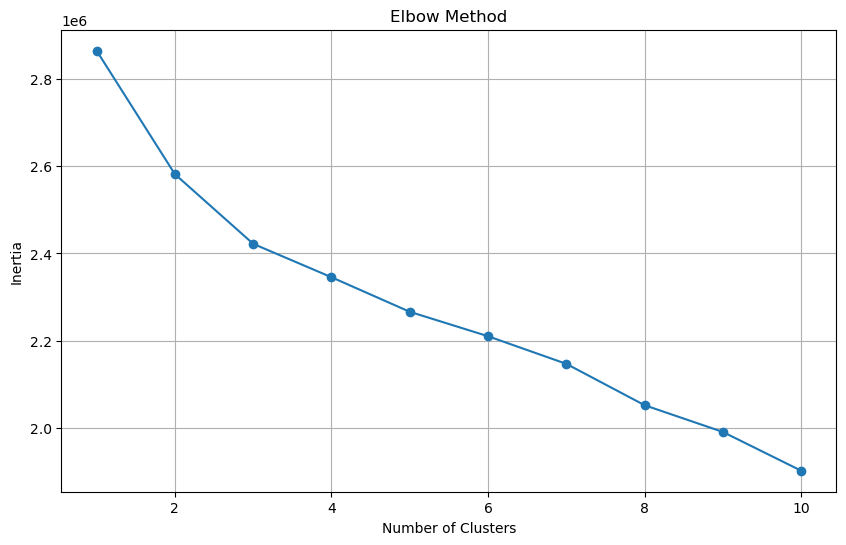

In [31]:
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

In [32]:
# Plot clusters for 2-cluster model (first two principal components)
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)

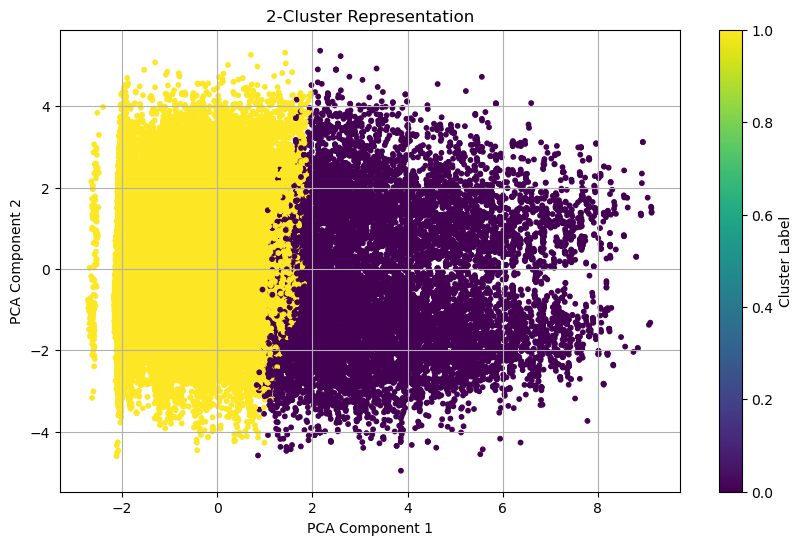

In [33]:
plt.figure(figsize=(10, 6))
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=labels_2, cmap='viridis', s=10)
plt.title('2-Cluster Representation')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster Label')
plt.grid(True)
plt.show()


In [34]:
print(f"Silhouette Score for 2 Clusters: {silhouette_2}")
print(f"Davies-Bouldin Index for 2 Clusters: {davies_2}")

Silhouette Score for 2 Clusters: 0.29555599508400177
Davies-Bouldin Index for 2 Clusters: 2.4962207911977123


In [35]:
# Summary of cluster characteristics
numeric_features = data_relevant.select_dtypes(include=['number']).columns
cluster_summary = data_relevant.groupby('cluster')[numeric_features].mean()
print("Resumo das Características por Cluster:")
print(cluster_summary)

Resumo das Características por Cluster:
         bathrooms  bedrooms  square_feet        AC     Alarm  Basketball  \
cluster                                                                     
0         1.400177  1.647381   893.645851  0.582637  0.017245    0.124191   
1         1.395754  1.651559   907.919775  0.065904  0.000491    0.025062   

         Cable or Satellite  Clubhouse  Dishwasher   Doorman  ...      Pool  \
cluster                                                       ...             
0                  0.525368   0.511418    0.705533  0.003178  ...  0.725427   
1                  0.040285   0.129898    0.046398  0.001193  ...  0.388262   

         Refrigerator   Storage        TV    Tennis      View  Washer Dryer  \
cluster                                                                       
0            0.603061  0.429959  0.094350  0.192878  0.033196      0.657681   
1            0.048599  0.176747  0.034928  0.064286  0.017795      0.179545   

         Wood Flo

In [41]:
# Gap Statistic Function
def gap_statistic(data, max_clusters, n_refs=10):
    gaps = []
    sk = []
    n_samples, n_features = data.shape
    ref_disps = np.zeros(n_refs)

    for k in range(1, max_clusters + 1):
        # Reference datasets (uniform distribution)
        for i in range(n_refs):
            random_data = np.random.uniform(
                low=np.min(data, axis=0), high=np.max(data, axis=0), size=data.shape
            )
            km = KMeans(n_clusters=k, n_init=10, random_state=42)
            km.fit(random_data)
            ref_disps[i] = np.sum(np.min(cdist(random_data, km.cluster_centers_, 'euclidean'), axis=1))

        # Fit KMeans to actual data
        km = KMeans(n_clusters=k, n_init=10, random_state=42)
        km.fit(data)
        intra_disp = np.sum(np.min(cdist(data, km.cluster_centers_, 'euclidean'), axis=1))

        # Calculate Gap Statistic
        gap = np.mean(np.log(ref_disps)) - np.log(intra_disp)
        gaps.append(gap)
        sk.append(np.std(np.log(ref_disps)) * np.sqrt(1 + 1 / n_refs))

    return np.array(gaps), np.array(sk)

# Calculate Gap Statistic
gaps, sk = gap_statistic(data_scaled, max_clusters=10)

# Display Gap Statistic results
for k in range(1, 11):
    print(f"K={k}, Gap: {gaps[k-1]:.4f}, Std Dev: {sk[k-1]:.4f}")

K=1, Gap: 1.4180, Std Dev: 0.0009
K=2, Gap: 1.1579, Std Dev: 0.0006
K=3, Gap: 1.1091, Std Dev: 0.0008
K=4, Gap: 1.0742, Std Dev: 0.0006
K=5, Gap: 1.0631, Std Dev: 0.0006
K=6, Gap: 1.0330, Std Dev: 0.0007
K=7, Gap: 1.0184, Std Dev: 0.0007
K=8, Gap: 1.0060, Std Dev: 0.0008
K=9, Gap: 0.9951, Std Dev: 0.0004
K=10, Gap: 0.9861, Std Dev: 0.0007


In [36]:
data_fixed.to_csv("C:/Users/afili/Desktop/Uni/Mestrado/AASE/CSVFinal_com_clusters.csv", index=False, sep=";")